<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/IITChatGPT4Worm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Read in data from: https://www.wormwideweb.org/dataset.html

Brain-wide representations of behavior spanning multiple timescales and states in C. elegans
Adam A. Atanas*, Jungsoo Kim*, Ziyu Wang, Eric Bueno, McCoy Becker, Di Kang, Jungyeon Park, Talya S. Kramer, Flossie K. Wan, Saba Baskoylu, Ugur Dag, Elpiniki Kalogeropoulou, Matthew A. Gomes, Cassi Estrem, Netta Cohen, Vikash K. Mansinghka, Steven W. Flavell
Cell 2023; doi: https://doi.org/10.1016/j.cell.2023.07.035
* equal contribution

In [1]:
from google.colab import files
import json

# Step 1: Upload the JSON file (to start, let's use: 2023-01-23-21)
uploaded = files.upload()

# Step 2: Read the JSON file
file_name = next(iter(uploaded))
rawdata = json.loads(uploaded[file_name].decode("utf-8"))

# Step 3: Access the z-scored ratiometric neural data
data = {}
data['neurodata'] = rawdata.get('trace_array', None)
data['neurolabels'] = rawdata.get('labeled', None)

# Check if both 'neurodata' and 'neurolabels' were found and print a message
if data['neurodata'] is not None and data['neurolabels'] is not None:
    print("Neural data detected")
else:
    print("Neural data not found in the JSON file.")

Saving 2023-01-23-21.json to 2023-01-23-21.json
Neural data detected


throw out what we do not need and save new variable

In [2]:
# Step 4: Save the 'data' variable to a JSON file
with open('data.json', 'w') as file:
    json.dump(data, file)

print("Data saved to 'data.json'")
del rawdata

Data saved to 'data.json'


# 2. Select 3 Neurons:
see
https://funconn.princeton.edu/
for functional connectivity
and
https://www.wormatlas.org/neurons/Individual%20Neurons/Neuronframeset.html
for details
[one Hebbian synapse for this dataset is: AVEL -> AIBL <- RIAR]

Enter the labels of three neurons. Available neuron labels:
AVEL, RMEL, AWAR, URYDL, I2L, SAAVL, I1R, RMDR, IL1DL, URYDR, SIBVL, RMER, SMDVR, RIAR, SAADL, M3R, RICR, AIM?, ADAL, RMDVR, AIBL, SMBV?, RMF?, OLQVL, RMEV, OLLL, RMDL, RMDDL, NSMR, AIZL, AVDR, URXR, AIZR, AVAL, IL2DL, RID, AQR, CEPDL, AVAR, RIBL, I2R, AVDL, AVJR, IL2L, NSML, AINR, RIMR, M4, IL1V?, AIYR, CEPVL, IL2R, AWCR, AWBR, OLQDR, IL1L, URYVR, MCR, AUAL, AWAL, RMDVL, RMGL, M3L, IL2VL, FLPL, AVER, RIVR, I3, AIBR, RMDDR, I1L, URXL, CEPVR, IL1V?, IL1DR, OLQDL, IL2VR, SMBV?, RMED, URBL, ASGL, ASHL, M5, AVJL, SMDVL, OLLR, RIVL, IL1R, MI, ADEL, URYVL, AWCL, AINL, MCL, AIYL, AVHL, ASGR, CEPDR, M1, RMF?, RICL, URBR
Enter neuron label 1: AVEL
Enter neuron label 2: AWAR
Enter neuron label 3: AIM?


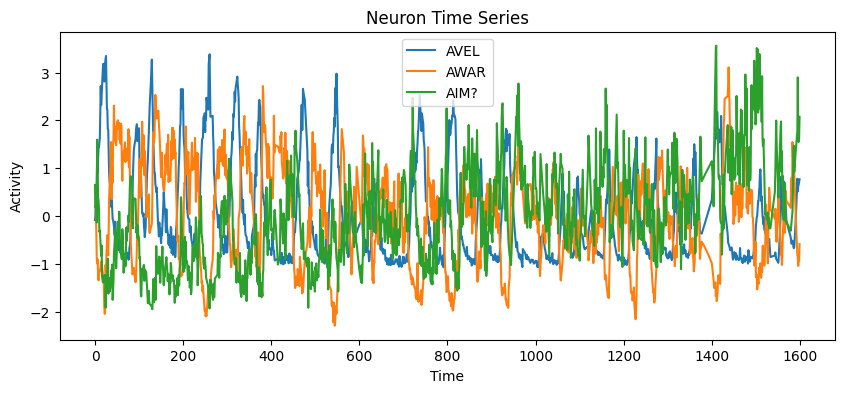

In [3]:
import matplotlib.pyplot as plt

# Extract neuron labels and time series data
neuron_labels = {key: value['label'] for key, value in data['neurolabels'].items()}
neuron_data = data['neurodata']

# Function to plot the selected neurons' time series
def plot_neuron_data(selected_neurons):
    plt.figure(figsize=(10, 4))
    for neuron in selected_neurons:
        neuron_index = list(neuron_labels.values()).index(neuron)
        plt.plot(neuron_data[neuron_index], label=neuron)
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title('Neuron Time Series')
    plt.legend()
    plt.show()

# Use input fields in Colab to select neurons
print("Enter the labels of three neurons. Available neuron labels:")
print(', '.join(neuron_labels.values()))  # Display all neuron labels

selected_neurons = []
for i in range(3):
    neuron = input(f"Enter neuron label {i+1}: ")
    if neuron in neuron_labels.values():
        selected_neurons.append(neuron)
    else:
        print(f"Neuron {neuron} not found. Please try again.")

# Plot the time series for the selected neurons
if len(selected_neurons) == 3:
    plot_neuron_data(selected_neurons)
else:
    print("Insufficient neurons selected for plotting.")


save the neuronal data

In [4]:
import pickle

with open('neuron_data.pkl', 'wb') as file:
    pickle.dump(neuron_data, file)

with open('neuron_labels.pkl', 'wb') as file:
    pickle.dump(neuron_labels, file)

with open('selected_neurons.pkl', 'wb') as file:
    pickle.dump(selected_neurons, file)

# 3. Plot cross-correlograms

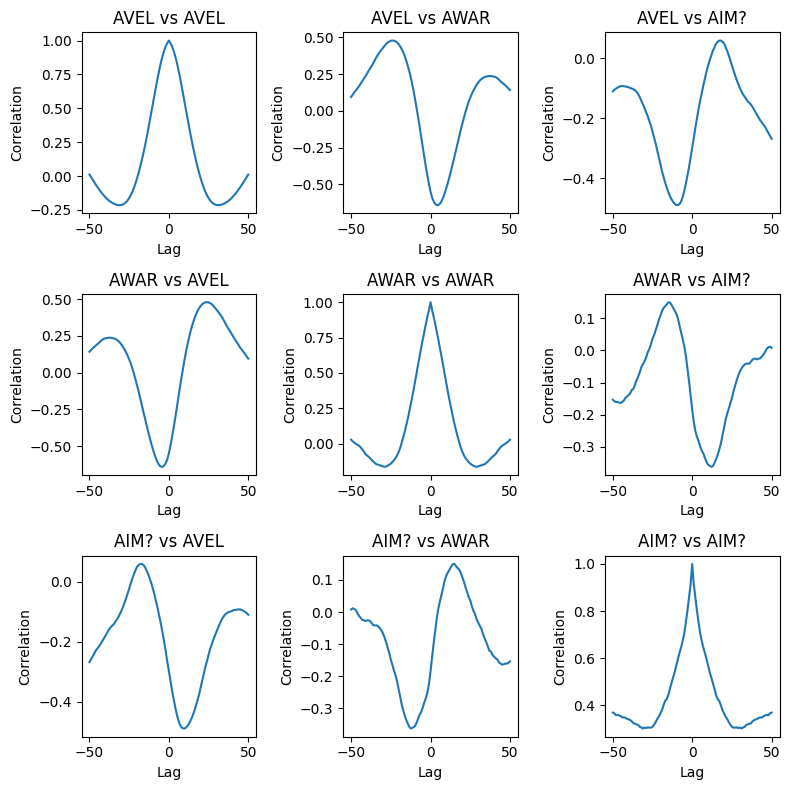

In [5]:
import numpy as np

def compute_cross_correlation(signal1, signal2, max_lag):
    """
    Compute the cross-correlation between two signals with a specified maximum lag.
    The function returns the cross-correlation and the corresponding lags.
    """
    correlation = np.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    correlation /= np.std(signal1) * np.std(signal2) * len(signal1)
    lags = np.arange(-max_lag, max_lag + 1)
    return correlation[len(correlation)//2 - max_lag: len(correlation)//2 + max_lag + 1], lags

# Define the maximum lag for the cross-correlation
max_lag = 50  # This value might need adjustment based on the time scale of your data

# Create a grid for the subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# For each pair of neurons, compute and plot the cross-correlation
for i, neuron1 in enumerate(selected_neurons):
    for j, neuron2 in enumerate(selected_neurons):
        ax = axes[i, j]
        # Find indices of the neurons
        neuron_index1 = list(neuron_labels.values()).index(neuron1)
        neuron_index2 = list(neuron_labels.values()).index(neuron2)

        # Compute cross-correlation
        correlation, lags = compute_cross_correlation(neuron_data[neuron_index1], neuron_data[neuron_index2], max_lag)

        # Plot the cross-correlation
        ax.plot(lags, correlation)
        ax.set_title(f'{neuron1} vs {neuron2}')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

NOTE: The WWW Sampling Rate was very low (1.4/1.7Hz).

# BINARIZE

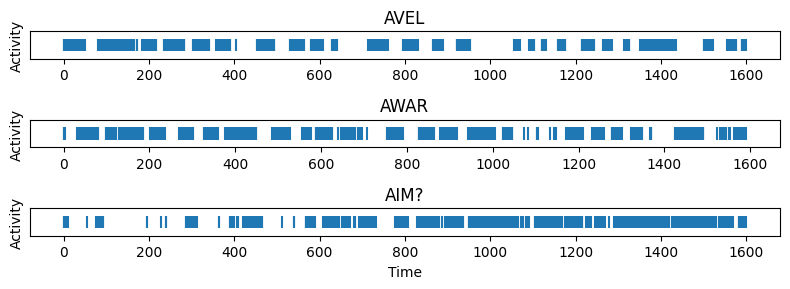

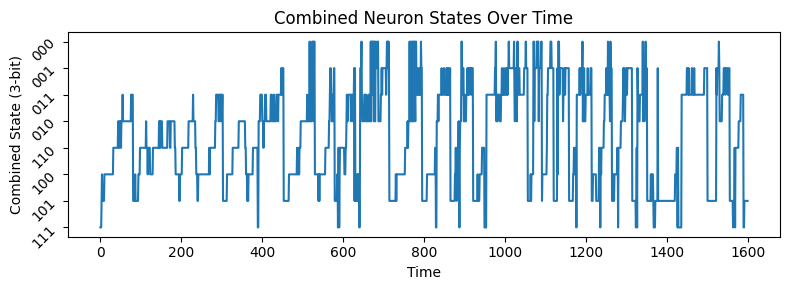

In [6]:
# Binarizing the selected neuron time series and creating raster plots

def binarize_and_plot_raster(neuron_data, neuron_labels, selected_neurons):
    fig, axes = plt.subplots(nrows=len(selected_neurons), ncols=1, figsize=(8, 3))

    # Binarizing and plotting each neuron
    binarized_data = []
    for i, neuron in enumerate(selected_neurons):
        neuron_index = list(neuron_labels.values()).index(neuron)
        neuron_series = neuron_data[neuron_index]
        median_value = np.median(neuron_series)
        binarized_series = np.where(neuron_series >= median_value, 1, 0)
        binarized_data.append(binarized_series)

        # Raster plot
        axes[i].eventplot(np.where(binarized_series == 1), lineoffsets=i, linelengths=0.8)
        axes[i].set_title(neuron)
        axes[i].set_ylabel('Activity')
        axes[i].set_yticks([])

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

    return binarized_data

# Binarizing the neuron data and plotting the raster plots
binarized_neuron_data = binarize_and_plot_raster(neuron_data, neuron_labels, selected_neurons)

# Combining the three time series into a single 3-bit time series
combined_series = np.array(binarized_neuron_data).T
combined_series_str = [''.join(map(str, point)) for point in combined_series]

# Plotting the combined 3-bit time series
plt.figure(figsize=(8, 3))
plt.plot(combined_series_str)
plt.xlabel('Time')
plt.ylabel('Combined State (3-bit)')
plt.title('Combined Neuron States Over Time')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# TPM

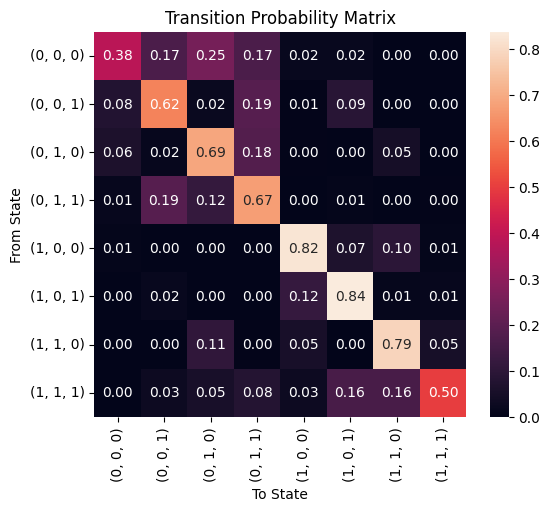

In [7]:
from itertools import product
from collections import defaultdict

def compute_transition_probability_matrix(time_series):
    """
    Compute the transition probability matrix for a given multi-dimensional time series.
    The function supports time series of varying lengths (more than two dimensions).
    """
    # Determine the number of elements in the time series
    num_elements = len(time_series[0])

    # Generate all possible states
    states = list(product([0, 1], repeat=num_elements))

    # Initialize the transition count matrix
    transition_counts = defaultdict(lambda: defaultdict(int))

    # Count transitions
    for i in range(1, len(time_series)):
        prev_state = tuple(time_series[i-1])
        curr_state = tuple(time_series[i])
        transition_counts[prev_state][curr_state] += 1

    # Convert counts to probabilities
    transition_probabilities = {}
    for state in states:
        total_transitions = sum(transition_counts[state].values())
        if total_transitions > 0:
            transition_probabilities[state] = {next_state: count / total_transitions
                                               for next_state, count in transition_counts[state].items()}
        else:
            # If no transitions from this state, fill with zeros
            transition_probabilities[state] = {next_state: 0 for next_state in states}

    return transition_probabilities, states

# Compute the transition probability matrix for the combined 3-bit time series
transition_prob_matrix, states = compute_transition_probability_matrix(combined_series)

import seaborn as sns

def plot_transition_matrix(transition_prob_matrix, states):
    """
    Plot the transition probability matrix as a 2D heatmap.
    """
    # Create a square matrix to represent the transitions
    matrix_size = len(states)
    transition_matrix = np.zeros((matrix_size, matrix_size))

    # Fill the matrix with probabilities
    for i, state_from in enumerate(states):
        for j, state_to in enumerate(states):
            transition_matrix[i, j] = transition_prob_matrix[state_from].get(state_to, 0)

    # Plotting the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_matrix, annot=True, fmt=".2f", xticklabels=states, yticklabels=states)
    plt.title('Transition Probability Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()
    return transition_matrix

# Plotting the transition matrix
transition_matrix = plot_transition_matrix(transition_prob_matrix, states)

# IIT

In [10]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

tpm = transition_matrix

# Check if a result file already exists to save time
if not os.path.exists('worm_phi_results.pkl'):

  # Record the start time
  start_time = time.time()

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 3), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state

      return phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  phi_results = calculate_phi_for_tpm(tpm, possible_states, labels)
  phi_values = phi_results[0]
  phi_states = phi_results[1]
  max_phi = phi_results[2]
  max_phi_state = phi_results[3]
  phi_mechanisms = phi_results[4]

  # Saving the results and the list of skipped trials
  with open('worm_phi_results.pkl', 'wb') as file:
    pickle.dump(phi_results, file)

  # Record the end time and calculate duration
  end_time = time.time()
  elapsed_time = end_time - start_time
  # Convert elapsed time into hours, minutes, and seconds
  hours = int(elapsed_time // 3600)
  minutes = int((elapsed_time % 3600) // 60)
  seconds = elapsed_time % 60

  elapsed_time_formatted = f"{hours} hours, {minutes} minutes, {seconds:.2f} seconds"

  print(f"Elapsed time for PHI computation: {elapsed_time_formatted}")

else:
    print("File 'worm_phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-pasntcdz
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-pasntcdz
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


2024-01-12 14:58:22,716	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Elapsed time for PHI computation: 0 hours, 0 minutes, 24.52 seconds


**PLOT**

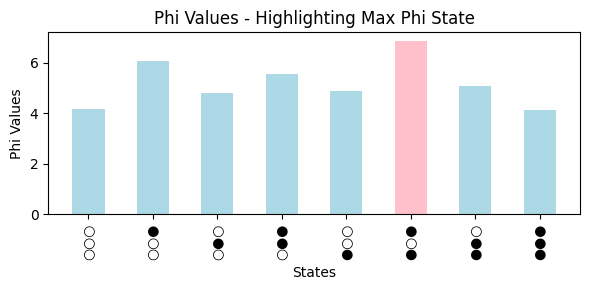

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming phi_results is already defined with the phi calculations

phi_values = phi_results[0]
phi_states = phi_results[1]
max_phi = phi_results[2]
max_phi_state = phi_results[3]
phi_mechanisms = phi_results[4]

# Convert states to symbolic representations for labeling
state_labels = [''.join('●' if bit == 1 else '○' for bit in state) for state in phi_states]

# Convert max_phi_state to the same symbolic representation
max_phi_state_label = ''.join('●' if bit == 1 else '○' for bit in max_phi_state)

# Define pastel colors
pastel_color = '#ADD8E6'  # Light blue
highlight_color = '#FFC0CB'  # Pastel red for highlighting max phi

# Creating the plot
fig, ax = plt.subplots(figsize=(6, 3))

# Plot Phi values
for state_label, phi_value in zip(state_labels, phi_values):
    color = highlight_color if state_label == max_phi_state_label else pastel_color
    ax.bar(state_label, phi_value, width=0.5, color=color)

# Setting titles and labels
ax.set_title('Phi Values - Highlighting Max Phi State')
ax.set_xlabel('States')
ax.set_ylabel('Phi Values')
ax.set_xticks(np.arange(len(state_labels)))
ax.set_xticklabels(state_labels, rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()